In [72]:
import numpy as np
from numpy.linalg import matrix_power
from numpy.linalg import inv
from numpy.random import gumbel
import networkx as nx
from networkx.convert_matrix import from_numpy_matrix
import matplotlib.pyplot as plt

## Groups

In [110]:
def group_initialize(n, ga_values_factor=1):
    """
    Initialize a group
    n: number of atoms
    """
    group_initial = np.random.choice(np.arange(n), size=(n,))
    ga_dict = dict({i:g for i,g in enumerate(group_initial)})
    # group assignment matrix: ga_matrix[i,k]=1 denotes node i belongs to kth group
    ga_matrix = np.zeros((n,n))
    ga_matrix[list(ga_dict.keys()), list(ga_dict.values())]=1
    ga_values = ga_values_factor*ga_matrix.copy()
    #group relation matrix: gr_matrix[i,j]=1 denotes i and j are in one group
    gr_matrix = np.zeros((n,n))
    for i in range(gr_matrix.shape[0]):
        for j in range(gr_matrix.shape[1]):
            if ga_dict[i]==ga_dict[j]:
                gr_matrix[i,j]=1
    return ga_dict, ga_matrix, ga_values, gr_matrix

In [15]:
ga_matrix, ga_values, gr_matrix = group_initialize(5,3)

In [16]:
ga_matrix

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [17]:
ga_values

array([[3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3.],
       [0., 0., 3., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 3.]])

In [18]:
gr_matrix

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.]])

Compute group assignment values according to group assignments and their ages
<br> $ga\_values[i,k]=ga[i,k]+(-1)^{ga[i,k]}\cdot K\cdot ga\_age[i,k]$
<br> Group Assignment values will increase with the group assignment age if $ga[i,k]=0$ otherwise it will decrease
<br> If the group assignment changes, the group assignment age and group assignment value will be reset

In [42]:
def compute_ga_values(ga_matrix, ga_ages, age_factor=0.1, ga_factor=3):
    """
    compute group assignment values 
    according to group assignment ages
    params:
      ga_matrix: group assignment matrix
      ga_ages: group assignment ages
      age_factor: to adjust the change of the 
    """
    return ga_factor*(ga_matrix+((-1)**ga_matrix)*age_factor*ga_ages)

In [73]:
def softmax(m, axis=1):
    """
    Compute the ga probabilities given ga_values
    parmas:
    m: ga_values 
    """
    m_exp = np.exp(m)
    m_exp_sum = np.diag(m_exp.sum(axis))
    m_exp_sum_inv = inv(m_exp_sum)
    m_prob = np.matmul(m_exp_sum_inv, m_exp)
    return m_prob

In [96]:
def sample_ga(ga_values):
    """
    Sample new group assignment based on ga values
    """
    atoms = np.arange(ga_values.shape[0])
    groups = np.arange(ga_values.shape[1])
    ga_probs = softmax(ga_values, axis=1)
    ga_dict = dict()
    for atom in atoms:
            ga_dict[atom]= np.random.choice(groups, p=ga_probs[atom])
    # group assignment matrix: ga_matrix[i,k]=1 denotes node i belongs to kth group
    ga_matrix = np.zeros((n,n))
    ga_matrix[list(ga_dict.keys()), list(ga_dict.values())]=1
    #group relation matrix: gr_matrix[i,j]=1 denotes i and j are in one group
    gr_matrix = np.zeros((n,n))
    for i in range(gr_matrix.shape[0]):
        for j in range(gr_matrix.shape[1]):
            if ga_dict[i]==ga_dict[j]:
                gr_matrix[i,j]=1
    return ga_dict, ga_matrix, gr_matrix

In [102]:
ga_dict, ga_matrix, gr_matrix = sample_ga(ga_values)

## Groups to interactions

$$p(I[i,j]=1|G[i,j])=1-exp(-k\cdot (G[i,j]+b))$$

In [136]:
# from group matrix to interaction matrix
def group_to_interaction(Group, k=3, b=0.1):
    I = np.zeros_like(Group)
    for i in range(Group.shape[0]):
        for j in range(Group.shape[1]):
            I[i,j] = np.random.choice([1,0],p=[1-np.exp(-k*(Group[i,j]+b)),np.exp(-k*(Group[i,j]+b))])
    np.fill_diagonal(I, 0)
    #Symmetric
    I = np.tril(I)+np.tril(I).T
    return I

In [137]:
#Initialize a group
ga_dict, ga_matrix, ga_values, gr_matrix = group_initialize(5,3)
print("Group Relations: \n", gr_matrix)

Group Relations: 
 [[1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1.]]


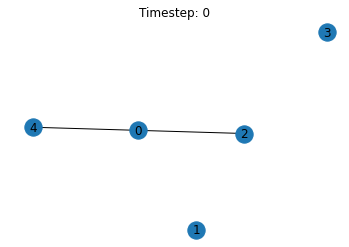

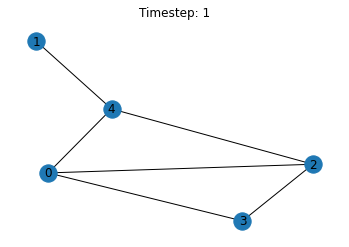

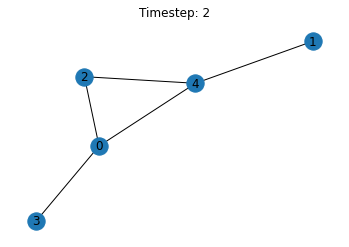

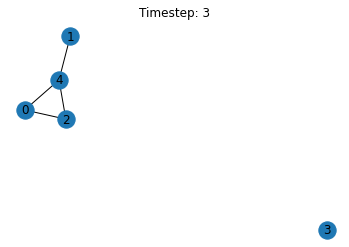

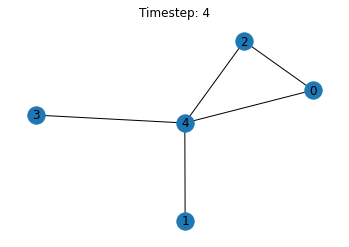

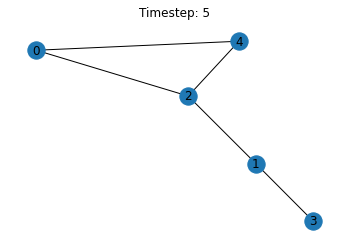

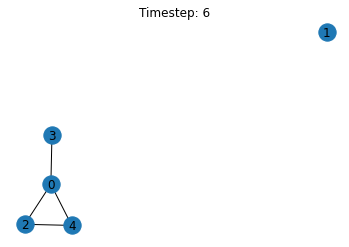

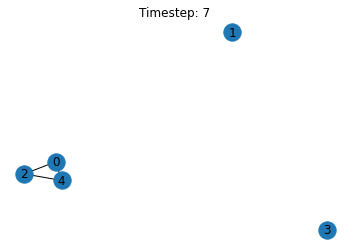

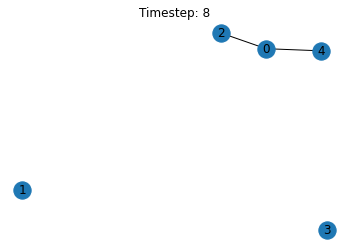

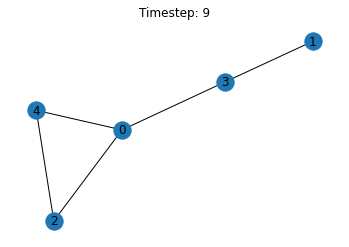

In [138]:
T = 10 #timesteps

for t in range(T):
    I_t = group_to_interaction(gr_matrix)
    plt.title("Timestep: %d"%t)
    nx.draw(nx.Graph(I_t), with_labels=True)
    plt.show()